In [1]:
# Much of this code is taken from:
# https://www.kaggle.com/code/kristinadoing/solving-arc-prize-2025-with-qwen-3-transformer/
# I am using their prompts and their formatting (except where noted)

import json
import os
import warnings
import ast
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
# Define paths to the datasets
training_solutions_path = '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json' if os.path.exists('/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json') else 'arc-agi_training_solutions.json'  
evaluation_solutions_path = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json' if os.path.exists('/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json') else 'arc-agi_evaluation_solutions.json' 
evaluation_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json' if os.path.exists('/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json') else 'arc-agi_evaluation_challenges.json'
sample_submission_path = '/kaggle/input/arc-prize-2025/sample_submission.json' if os.path.exists('/kaggle/input/arc-prize-2025/sample_submission.json') else 'sample_submission.json' 
training_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json' if os.path.exists('/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json') else 'arc-agi_training_challenges.json'
test_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json' if os.path.exists('/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json') else 'arc-agi_test_challenges.json'


In [3]:
# Load the training data
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

training_solutions = load_json(training_solutions_path)
evaluation_solutions = load_json(evaluation_solutions_path)
evaluation_challenges = load_json(evaluation_challenges_path)
sample_submission = load_json(sample_submission_path)
training_challenges = load_json(training_challenges_path)
test_challenges = load_json(test_challenges_path)

In [4]:
# Gemini 2.5 - Model loading and setup (no CUDA, runs remotely)
# from here: https://ai.google.dev/gemini-api/docs/quickstart

from google import genai
from google.genai import types
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

MODEL_ID = "models/gemini-2.5-flash-preview-04-17"

In [14]:
# --- Example from the ARC dataset ---
# Let's try to answer one of the training challenges.
sample_challenge_id = list(training_challenges.keys())  # Get the first challenge ID
print(f"There are {len(sample_challenge_id)} challenges")
sample_challenge_id = sample_challenge_id[1]
challenge = training_challenges[sample_challenge_id]
print(f"There are {len(challenge['test'])} test cases")
solution = training_solutions[sample_challenge_id]
print(f"There are {len(solution)} solutions")

There are 1000 challenges
There are 1 test cases
There are 1 solutions


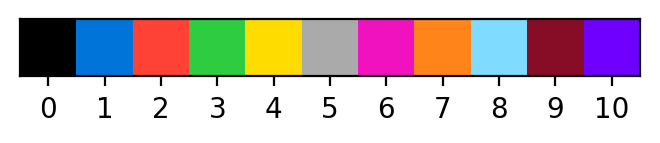

In [6]:
# Visualize the examples
# From: https://www.kaggle.com/code/alejandrolopezrincon/starting-point-separating-objects
import matplotlib.pyplot as plt
from   matplotlib import colors
import numpy as np

# Get a color map array to display data as array of colors
cmap = colors.ListedColormap(['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
                                  '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25',
                                   '#6F00FF',])

#An Extra color for some operations

norm = colors.Normalize(vmin=0, vmax=10)

plt.figure(figsize=(4, 1), dpi=200)
plt.imshow([list(range(11))], cmap=cmap, norm=norm)
plt.xticks(list(range(11)))
plt.yticks([])
plt.show()

def plotMat(mat, title):
    input_matrix = np.array(mat)
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    # ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)

    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))

    ax.set_title(title)

    plt.show()
    return
    
def plotMat2(mat1, mat2, title):
    mat1 = np.array(mat1)
    mat2 = np.array(mat2)

    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))  # 1 row, 2 columns

    axs[0].imshow(mat1, cmap=cmap, norm=norm)
    axs[0].yaxis.set_major_locator(plt.MultipleLocator(1.0))
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(1.0))
    axs[1].imshow(mat2, cmap=cmap, norm=norm)
    axs[1].yaxis.set_major_locator(plt.MultipleLocator(1.0))
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(1.0))

    # Remove tick labels
    plt.setp(axs, xticklabels=[], yticklabels=[])

    # Set a shared title
    fig.suptitle(title)

    plt.show()

    return

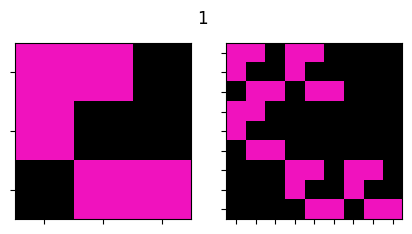

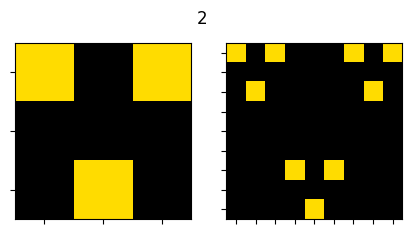

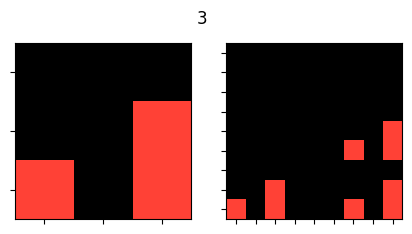

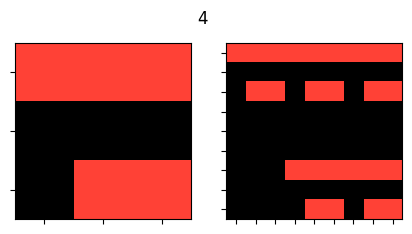

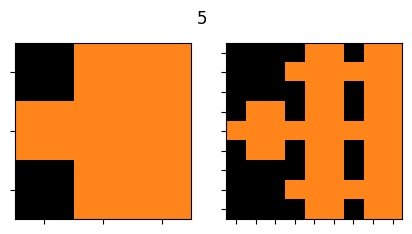

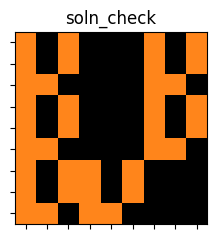

In [15]:
for i, task in enumerate(challenge['train']): 
    plotMat2(task['input'], task['output'], i+1)
plotMat(solution[0], 'soln_check')

In [16]:
# This prompt is my own for the most part
# --- Example of reasoning the ARC dataset ---

# Construct a prompt to reason over the provided examples
prompt = "The following are examples from an abstract reasoning challenge.\n"  
prompt += "Recall all the attributes associated with numbers "
prompt += "(e.g., even/odd, big/small, format within the grid, etc.) and look at these examples:\n"

for i, task in enumerate(challenge['train']): # Use examples from the training set to build the prompt
     prompt += f"Input {i+1}:\n"
     prompt += str(task['input']) + "\n"
     prompt += f"Output {i+1}:\n"
     prompt += str(task['output']) + "\n\n"

# Add the test input.  Tell the model to predict this output
prompt += "Describe the similarities and differences of the examples with "
prompt += "respect to numbers and their attributes (in 100 words or less):\n\n"  # Ask the model to reason

# Generate the response
print("----------------------")
# Gemimi 2.5
response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt
)
reasoning = response.text
print(f"Model's Reasoning:\n{reasoning}")
print("----------------------")

----------------------
Model's Reasoning:
The core attributes determining the transformation are whether a number is zero or non-zero.

*   **Similarities:** All examples use integer numbers. The number 0 consistently dictates an all-zero 3x3 block in the output. Non-zero numbers (regardless of specific value like 6, 4, 2, or 7) consistently dictate a copy of the *entire* input grid as a 3x3 block in the output.
*   **Differences:** The specific non-zero values used vary. The pattern of zero and non-zero numbers in the input varies, which changes the arrangement of zero blocks and input-copy blocks in the 9x9 output.
----------------------


----------------------
Solving ARC Challenge:
Challenge ID: 007bbfb7
data:


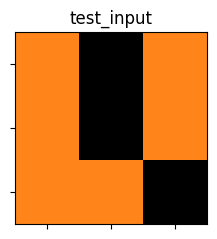

Model's Prediction first then truth


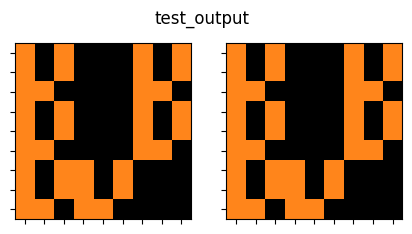

In [18]:
# Prompt changed by me.
# This prompt doesn't work!! Except when it does???

# --- Example of integrating with the ARC dataset ---

# Construct a prompt that describes the task and provides examples
prompt = f"Given your observations {reasoning}, "
# Add the test input.  Tell the model to predict this output
prompt += "now, predict the output for the following test input:\n"
prompt += str(challenge['test'][0]['input']) + "\n"
prompt += "Output:\n"  # Ask the model to generate the output

# Generate the response
print("----------------------")
print("Solving ARC Challenge:")
print(f"Challenge ID: {sample_challenge_id}")
print("data:")
plotMat(challenge['test'][0]['input'], 'test_input')
# Gemimi 2.5
arc_response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt
)
arc_response = arc_response.text.replace(" ", "").replace("\n", "")
start, end = arc_response.rfind("[["), arc_response.rfind("]]")
if start != -1 and end != -1:
    predicted_grid = ast.literal_eval(arc_response[start:end + 2])
else:
    predicted_grid = [[0, 0]]  # Fallback grid

print("Model's Prediction first then truth")
plotMat2(predicted_grid, solution[0], 'test_output')

----------------------
Solving ARC Challenge:
Challenge ID: 007bbfb7
data:


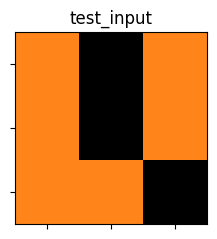

Model's Prediction first then truth


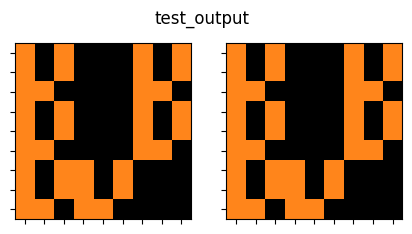

In [19]:
# --- Example of integrating with the ARC dataset No separate planning ---

# Construct a prompt that describes the task and provides examples
prompt = f"Solve the following abstract reasoning challenge.  Here's the challenge:\n\n"
for i, task in enumerate(challenge['train']): # Use examples from the training set to build the prompt
     prompt += f"Input {i+1}:\n"
     prompt += str(task['input']) + "\n"
     prompt += f"Output {i+1}:\n"
     prompt += str(task['output']) + "\n\n"

# Add the test input.  Tell the model to predict this output
prompt += "Now, predict the output for the following test input:\n"
prompt += str(challenge['test'][0]['input']) + "\n"
prompt += "Output:\n"  # Ask the model to generate the output

# Generate the response
print("----------------------")
print("Solving ARC Challenge:")
print(f"Challenge ID: {sample_challenge_id}")
print("data:")
plotMat(challenge['test'][0]['input'], 'test_input')
# Gemimi 2.5
arc_response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt
)
arc_response = arc_response.text.replace(" ", "").replace("\n", "")
start, end = arc_response.rfind("[["), arc_response.rfind("]]")
if start != -1 and end != -1:
    predicted_grid = ast.literal_eval(arc_response[start:end + 2])
else:
    predicted_grid = [[0, 0]]  # Fallback grid

print("Model's Prediction first then truth")
plotMat2(predicted_grid, solution[0], 'test_output')

In [20]:
# Challenge solving function
def solve_arc_challenge(challenge):
    predictions = []

    # Prebuild train prompt
    train_prompt = "Solve the following abstract reasoning challenge. Here's the challenge:\n\n"
    for i, example in enumerate(challenge['train']):
        train_prompt += f"Input {i + 1}:\n{example['input']}\nOutput {i + 1}:\n{example['output']}\n\n"

    for test_input in challenge['test']:
        prompt = train_prompt + f"Now, predict the output for the following test input:\n{test_input['input']}\nOutput:\n"

        try:
            # Gemimi 2.5
            arc_response = client.models.generate_content(
                model=MODEL_ID,
                contents=prompt
            )
            arc_response = arc_response.text.replace(" ", "").replace("\n", "")
            start, end = arc_response.rfind("[["), arc_response.rfind("]]")
            if start != -1 and end != -1:
                predicted_grid = ast.literal_eval(arc_response[start:end + 2])
            else:
                predicted_grid = [[0, 0]]  # Fallback grid
        except Exception as e:
            print(f"⚠️ Failed to parse output: {e}")
            predicted_grid = [[0, 0]]

        predictions.append(predicted_grid)
    return predictions

In [22]:
# Evaluation loop
def create_submission(evaluation_challenges):
    submission = {}
    for task_id, challenge in tqdm(evaluation_challenges.items(), desc="Solving ARC tasks"):
        predictions = solve_arc_challenge(challenge)
        submission[task_id] = [{"attempt_1": p, "attempt_2": p} for p in predictions]
    return submission

# Main
if __name__ == "__main__":
    submission = create_submission(evaluation_challenges)
    with open('submission.json', 'w') as f:
        json.dump(submission, f)
    print("✅ Submission saved to `submission.json`.")

Solving ARC tasks:   6%|▌         | 7/120 [27:18<7:52:02, 250.64s/it]

⚠️ Failed to parse output: unmatched ']' (<unknown>, line 1)


Solving ARC tasks:   8%|▊         | 9/120 [36:03<8:13:41, 266.86s/it]

⚠️ Failed to parse output: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
⚠️ Failed to parse output: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
⚠️ Failed to parse output: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}


Solving ARC tasks:   8%|▊         | 10/120 [36:54<6:06:59, 200.18s/it]

⚠️ Failed to parse output: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
⚠️ Failed to parse output: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}


Solving ARC tasks:   9%|▉         | 11/120 [40:35<6:42:11, 221.39s/it]


KeyboardInterrupt: 